In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In [3]:
os.makedirs('.../inputs/gaussian_blurred', exist_ok=True)
src_dir = '.../inputs/sharp'
images = os.listdir(src_dir)
dst_dir = '.../inputs/gaussian_blurred'

In [4]:
for i, img in tqdm(enumerate(images), total=len(images)):
    img = cv2.imread(f"{src_dir}/{images[i]}", cv2.IMREAD_COLOR)
    # add gaussian blurring
    blur = cv2.GaussianBlur(img, (31, 31), 0)
    cv2.imwrite(f"{dst_dir}/{images[i]}", blur)
print('DONE')

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:33<00:00, 10.56it/s]

DONE


In [5]:
epochs = 40
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

In [6]:
image_dir = '.../outputs/saved_images'
os.makedirs(image_dir, exist_ok=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 2

cuda:0


In [7]:
gauss_blur = os.listdir('.../inputs/gaussian_blurred')
gauss_blur.sort()
sharp = os.listdir('.../inputs/sharp')
sharp.sort()
x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])
y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

In [8]:
(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

Train data instances: 262
Validation data instances: 88


In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [10]:
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        blur_image = cv2.imread(f".../inputs/gaussian_blurred/{self.X[i]}")
        
        if self.transforms:
            blur_image = self.transforms(blur_image)
            
        if self.y is not None:
            sharp_image = cv2.imread(f".../inputs/sharp/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image

In [11]:
train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)
 
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [12]:
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
model = DeblurCNN().to(device)
print(model)

DeblurCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [13]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        verbose=True
    )

C:\Users\aditu\anaconda3\envs\tf2.10\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss

In [15]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(sharp_image.cpu().data, name=f".../outputs/saved_images/sharp{epoch}.jpg")
                save_decoded_image(blur_image.cpu().data, name=f".../outputs/saved_images/blur{epoch}.jpg")
            if i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(outputs.cpu().data, name=f".../outputs/saved_images/val_deblurred{epoch}.jpg")
        val_loss = running_loss/len(dataloader.dataset)
        print(f"Val Loss: {val_loss:.5f}")
        
        return val_loss

In [17]:
train_loss  = []
val_loss = []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 1 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:43<00:00,  2.98it/s]


Train Loss: 0.01079


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:11<00:00,  3.93it/s]


Val Loss: 0.00273
Epoch 2 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:31<00:00,  4.21it/s]


Train Loss: 0.00234


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.16it/s]


Val Loss: 0.00157
Epoch 3 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:31<00:00,  4.12it/s]


Train Loss: 0.00184


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.15it/s]


Val Loss: 0.00130
Epoch 4 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:31<00:00,  4.13it/s]


Train Loss: 0.00160


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.13it/s]


Val Loss: 0.00116
Epoch 5 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:32<00:00,  4.09it/s]


Train Loss: 0.00150


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.10it/s]


Val Loss: 0.00102
Epoch 6 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:31<00:00,  4.19it/s]


Train Loss: 0.00119


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.16it/s]


Val Loss: 0.00090
Epoch 7 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:31<00:00,  4.12it/s]


Train Loss: 0.00105


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.18it/s]


Val Loss: 0.00095
Epoch 8 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:28<00:00,  4.52it/s]


Train Loss: 0.00102


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.02it/s]


Val Loss: 0.00086
Epoch 9 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:31<00:00,  4.17it/s]


Train Loss: 0.00136


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.45it/s]


Val Loss: 0.00070
Epoch 10 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.42it/s]


Train Loss: 0.00085


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.60it/s]


Val Loss: 0.00065
Epoch 11 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.41it/s]


Train Loss: 0.00080


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.56it/s]


Val Loss: 0.00065
Epoch 12 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.29it/s]


Train Loss: 0.00071


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.36it/s]


Val Loss: 0.00056
Epoch 13 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.38it/s]


Train Loss: 0.00073


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.60it/s]


Val Loss: 0.00054
Epoch 14 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.39it/s]


Train Loss: 0.00141


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.35it/s]


Val Loss: 0.00058
Epoch 15 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.33it/s]


Train Loss: 0.00065


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.40it/s]


Val Loss: 0.00050
Epoch 16 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.28it/s]


Train Loss: 0.00059


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.40it/s]


Val Loss: 0.00051
Epoch 17 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.37it/s]


Train Loss: 0.00057


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.41it/s]


Val Loss: 0.00047
Epoch 18 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.38it/s]


Train Loss: 0.00058


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.43it/s]


Val Loss: 0.00040
Epoch 19 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.35it/s]


Train Loss: 0.00049


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.44it/s]


Val Loss: 0.00041
Epoch 20 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.39it/s]


Train Loss: 0.00047


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.58it/s]


Val Loss: 0.00042
Epoch 21 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.38it/s]


Train Loss: 0.00056


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.60it/s]


Val Loss: 0.00108
Epoch 22 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.38it/s]


Train Loss: 0.00062


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.55it/s]


Val Loss: 0.00036
Epoch 23 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.37it/s]


Train Loss: 0.00044


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.54it/s]


Val Loss: 0.00035
Epoch 24 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.34it/s]


Train Loss: 0.00043


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.37it/s]


Val Loss: 0.00034
Epoch 25 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.28it/s]


Train Loss: 0.00044


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.36it/s]


Val Loss: 0.00032
Epoch 26 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.29it/s]


Train Loss: 0.00050


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.32it/s]


Val Loss: 0.00053
Epoch 27 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.29it/s]


Train Loss: 0.00045


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.41it/s]


Val Loss: 0.00031
Epoch 28 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.30it/s]


Train Loss: 0.00039


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.29it/s]


Val Loss: 0.00033
Epoch 29 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.26it/s]


Train Loss: 0.00036


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.32it/s]


Val Loss: 0.00028
Epoch 30 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:31<00:00,  4.22it/s]


Train Loss: 0.00054


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.24it/s]


Val Loss: 0.00055
Epoch 31 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.25it/s]


Train Loss: 0.00087


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.29it/s]


Val Loss: 0.00075
Epoch 32 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.27it/s]


Train Loss: 0.00056


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.30it/s]


Val Loss: 0.00029
Epoch 33 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.26it/s]


Train Loss: 0.00040


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.30it/s]


Val Loss: 0.00027
Epoch 34 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.25it/s]


Train Loss: 0.00034


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.25it/s]


Val Loss: 0.00025
Epoch 35 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.23it/s]


Train Loss: 0.00033


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.27it/s]


Val Loss: 0.00026
Epoch 36 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:29<00:00,  4.38it/s]


Train Loss: 0.00031


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.90it/s]


Val Loss: 0.00023
Epoch 37 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:28<00:00,  4.53it/s]


Train Loss: 0.00030


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.79it/s]


Val Loss: 0.00027
Epoch 38 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.25it/s]


Train Loss: 0.00045


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.30it/s]


Val Loss: 0.00069
Epoch 39 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.27it/s]


Train Loss: 0.00043


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.35it/s]


Val Loss: 0.00022
Epoch 40 of 40


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:30<00:00,  4.27it/s]


Train Loss: 0.00026


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:08<00:00,  5.37it/s]

Val Loss: 0.00020
Took 26.082 minutes to train


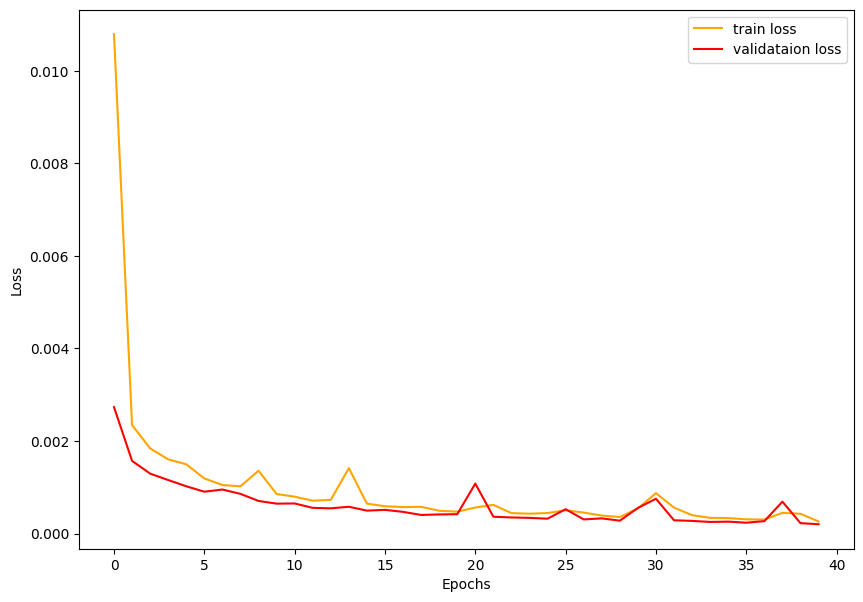

Saving model...


In [19]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('.../outputs/loss.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '.../outputs/model.pth')

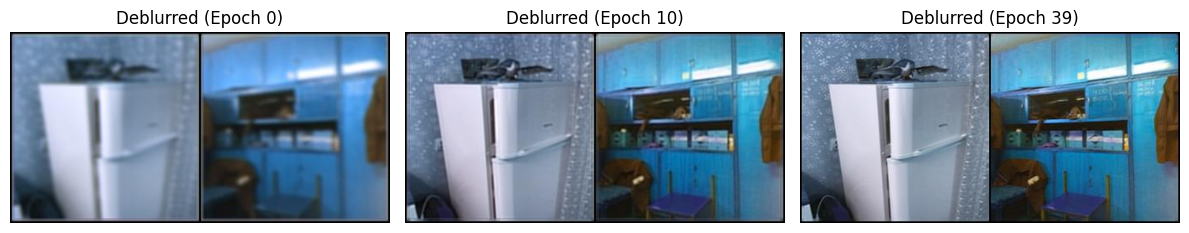

In [28]:
import matplotlib.pyplot as plt
import cv2

epochs = [0, 10, 39]

base_path = ".../outputs/saved_images/"

plt.figure(figsize=(12, 6))

for idx, epoch in enumerate(epochs):
    deblurred_path = f"{base_path}/val_deblurred{epoch}.jpg"
    
    deblurred_img = cv2.imread(deblurred_path)
    deblurred_img = cv2.cvtColor(deblurred_img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, idx + 4)
    plt.imshow(deblurred_img)
    plt.title(f"Deblurred (Epoch {epoch})")
    plt.axis('off')

plt.tight_layout()
plt.show()